In [1]:
import os
from PIL import Image

def downsample_image(image, scale_factor):

    width, height = image.size
    new_size = (width // scale_factor, height // scale_factor)
    downsampled_image = image.resize(new_size, Image.BICUBIC)

    low_quality_image = downsampled_image.resize((width, height), Image.BICUBIC)
    return low_quality_image


def prepare_data(hr_image_dir, lr_image_dir, scale_factor=2):
    if not os.path.exists(lr_image_dir):
        os.makedirs(lr_image_dir)
    hr_images = os.listdir(hr_image_dir)
    for img_name in hr_images:
        hr_image_path = os.path.join(hr_image_dir, img_name)
        lr_image_path = os.path.join(lr_image_dir, img_name)

        hr_image = Image.open(hr_image_path).convert('RGB')
        lr_image = downsample_image(hr_image, scale_factor)
        lr_image.save(lr_image_path)


In [2]:
prepare_data('./high_res', 'low_res', scale_factor=2)

In [4]:
import torch
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = SRCNN()


In [69]:
import torch
import torch.nn as nn

class ModifiedSRCNN(nn.Module):
    def __init__(self):
        super(ModifiedSRCNN, self).__init__()

        # First layer: 9x9 convolution with 64 filters
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)

        # Second layer: 3x3 convolution with 32 filters
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)


        # Third layer: 3x3 convolution with 32 filters
        self.layer3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)


        # Activation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))  # Apply dropout here
        x = self.layer3(x)
        return x

# Apply this to your model after defining it
modified_model = ModifiedSRCNN()


In [80]:
import torch
import torch.nn as nn
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self, weight_mse=1.0, weight_perceptual=0.1, device='cuda'):
        super(PerceptualLoss, self).__init__()

        # Pre-trained VGG model for perceptual loss
        vgg = models.vgg19(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(vgg)[:18]).eval()  # Use up to the 18th layer
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze VGG layers

        # Move the feature extractor to the specified device
        self.feature_extractor.to(device)

        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.weight_mse = weight_mse
        self.weight_perceptual = weight_perceptual
        self.device = device

    def forward(self, sr, hr):
        # Ensure sr and hr are on the correct device
        sr = sr.to(self.device)
        hr = hr.to(self.device)

        # Compute pixel-wise MSE loss
        mse_loss = self.mse_loss(sr, hr)

        # Extract features using VGG for perceptual loss
        sr_features = self.feature_extractor(sr)
        hr_features = self.feature_extractor(hr)
        perceptual_loss = self.mse_loss(sr_features, hr_features)

        # Combine the losses
        total_loss = (self.weight_mse * mse_loss) + (self.weight_perceptual * perceptual_loss)
        return total_loss

# Example usage:
# Set the device ('cuda' if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the combined perceptual loss
criterion = PerceptualLoss(weight_mse=1.0, weight_perceptual=0.1, device=device)


#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)


In [71]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_images = sorted([os.path.join(lr_dir, x) for x in os.listdir(lr_dir)])
        self.hr_images = sorted([os.path.join(hr_dir, x) for x in os.listdir(hr_dir)])
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(self.lr_images[idx]).convert('RGB')
        hr_image = Image.open(self.hr_images[idx]).convert('RGB')
        lr_image = self.to_tensor(lr_image)
        hr_image = self.to_tensor(hr_image)
        return lr_image, hr_image


In [72]:
from torch.utils.data import random_split
import os

batch_size = 16
train_dataset = SRDataset('./low_res', './high_res')

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [73]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [74]:
def train_model(model, num_epochs, minimum_delta):
    early_stopping = EarlyStopping(patience=10, min_delta=minimum_delta)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for lr_imgs, hr_imgs in train_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            optimizer.zero_grad()
            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for lr_imgs, hr_imgs in val_loader:
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)
                sr_imgs = model(lr_imgs)
                loss = criterion(sr_imgs, hr_imgs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss)

        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break


In [84]:
train_model(model, 100, 0.00001)

Epoch [1/100], Train Loss: 0.0880, Val Loss: 0.0833
Epoch [2/100], Train Loss: 0.0874, Val Loss: 0.0831
Epoch [3/100], Train Loss: 0.0875, Val Loss: 0.0829
Epoch [4/100], Train Loss: 0.0875, Val Loss: 0.0828
Epoch [5/100], Train Loss: 0.0876, Val Loss: 0.0827
Epoch [6/100], Train Loss: 0.0888, Val Loss: 0.0826
Epoch [7/100], Train Loss: 0.0873, Val Loss: 0.0825
Epoch [8/100], Train Loss: 0.0866, Val Loss: 0.0824
Epoch [9/100], Train Loss: 0.0865, Val Loss: 0.0823
Epoch [10/100], Train Loss: 0.0878, Val Loss: 0.0822
Epoch [11/100], Train Loss: 0.0873, Val Loss: 0.0821
Epoch [12/100], Train Loss: 0.0870, Val Loss: 0.0820
Epoch [13/100], Train Loss: 0.0865, Val Loss: 0.0820
Epoch [14/100], Train Loss: 0.0869, Val Loss: 0.0819
Epoch [15/100], Train Loss: 0.0879, Val Loss: 0.0818
Epoch [16/100], Train Loss: 0.0885, Val Loss: 0.0817
Epoch [17/100], Train Loss: 0.0868, Val Loss: 0.0817
Epoch [18/100], Train Loss: 0.0873, Val Loss: 0.0816
Epoch [19/100], Train Loss: 0.0858, Val Loss: 0.0815
Ep

In [85]:
torch.save(model.state_dict(), './super_res_model_state_dict1.pth')

In [81]:
train_model(modified_model, 100, 0.0001)

Epoch [1/100], Train Loss: 0.6745, Val Loss: 0.6591
Epoch [2/100], Train Loss: 0.6747, Val Loss: 0.6591
Epoch [3/100], Train Loss: 0.6728, Val Loss: 0.6591
Epoch [4/100], Train Loss: 0.6774, Val Loss: 0.6591
Epoch [5/100], Train Loss: 0.6755, Val Loss: 0.6591
Epoch [6/100], Train Loss: 0.6765, Val Loss: 0.6591
Epoch [7/100], Train Loss: 0.6742, Val Loss: 0.6591
Epoch [8/100], Train Loss: 0.6751, Val Loss: 0.6591
Epoch [9/100], Train Loss: 0.6774, Val Loss: 0.6591
Epoch [10/100], Train Loss: 0.6748, Val Loss: 0.6591
Epoch [11/100], Train Loss: 0.6759, Val Loss: 0.6591
Early stopping triggered. Stopping training.


In [38]:
# import matplotlib.pyplot as plt

# def display_images(lr_image, sr_image_1, sr_image_2, hr_image=None):
#     plt.figure(figsize=(20, 5))

#     # Low-Resolution Image
#     plt.subplot(1, 4, 1)
#     plt.imshow(lr_image)
#     plt.title('Low Resolution')
#     plt.axis('off')

#     # Super-Resolution Image from the First Model
#     plt.subplot(1, 4, 2)
#     plt.imshow(sr_image_1)
#     plt.title('Super Resolution (Model 1: less layers)')
#     plt.axis('off')

#     # Super-Resolution Image from the Second Model
#     plt.subplot(1, 4, 3)
#     plt.imshow(sr_image_2)
#     plt.title('Super Resolution (Model 2: more layers)')
#     plt.axis('off')

#     # High-Resolution Image
#     if hr_image is not None:
#         plt.subplot(1, 4, 4)
#         plt.imshow(hr_image)
#         plt.title('High Resolution')
#         plt.axis('off')

#     plt.show()

In [86]:
import matplotlib.pyplot as plt

def display_images(lr_image, sr_image, hr_image=None):
    plt.figure(figsize=(15, 5))
    # Low-Resolution Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low Resolution')
    plt.axis('off')
    # Super-Resolution Image
    plt.subplot(1, 3, 2)
    plt.imshow(sr_image)
    plt.title('Super Resolution')
    plt.axis('off')
    # High-Resolution Image
    if hr_image is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(hr_image)
        plt.title('High Resolution (Ground Truth)')
        plt.axis('off')
    plt.show()

In [39]:
# from math import log10
# import torch.nn.functional as F
# import numpy as np
# from skimage import metrics

# def psnr(sr, hr):
#     mse = F.mse_loss(sr, hr)
#     if mse == 0:
#         return float('inf')
#     return 20 * log10(1.0 / torch.sqrt(mse))

# # Lists to store evaluation metrics for both models
# original_loss_values = []
# original_psnr_values = []
# modified_loss_values = []
# modified_psnr_values = []

# def evaluate_images(original_model, modified_model, lr_image_dir, hr_image_dir, num_images=15):
#     lr_images = sorted(os.listdir(lr_image_dir))[:num_images]
#     hr_images = sorted(os.listdir(hr_image_dir))[:num_images]

#     for i, (lr_img_name, hr_img_name) in enumerate(zip(lr_images, hr_images)):
#         lr_image_path = os.path.join(lr_image_dir, lr_img_name)
#         hr_image_path = os.path.join(hr_image_dir, hr_img_name)

#         # Load images
#         lr_image = Image.open(lr_image_path).convert('RGB')
#         hr_image = Image.open(hr_image_path).convert('RGB')

#         # Convert images to tensors
#         lr_tensor = ToTensor()(lr_image).unsqueeze(0).to(device)
#         hr_tensor = ToTensor()(hr_image).unsqueeze(0).to(device)

#         # Evaluate original model
#         with torch.no_grad():
#             sr_tensor = model(lr_tensor)
#         psnr_value_original = psnr(sr_tensor, hr_tensor)
#         original_psnr_values.append(psnr_value_original)

#         loss_original = criterion(sr_tensor, hr_tensor)
#         original_loss_values.append(loss_original.item())

#         # Evaluate modified model
#         with torch.no_grad():
#             sr_tensor_modified = modified_model(lr_tensor)
#         psnr_value_modified = psnr(sr_tensor_modified, hr_tensor)
#         modified_psnr_values.append(psnr_value_modified)

#         loss_modified = criterion(sr_tensor_modified, hr_tensor)
#         modified_loss_values.append(loss_modified.item())

#         # Convert tensors to images for display
#         sr_image_original = sr_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
#         sr_image_original = np.clip(sr_image_original, 0, 1)

#         sr_image_modified = sr_tensor_modified.squeeze(0).cpu().permute(1, 2, 0).numpy()
#         sr_image_modified = np.clip(sr_image_modified, 0, 1)

#         # Display images for comparison
#         display_images(lr_image, sr_image_original, sr_image_modified, hr_image)


In [90]:
from math import log10
import torch.nn.functional as F
import numpy as np
from skimage import metrics

def psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    if mse == 0:
        return float('inf')
    return 20 * log10(1.0 / torch.sqrt(mse))

loss_values = []
psnr_values = []

def evaluate_images(model, lr_image_dir, hr_image_dir, num_images=15):

    lr_images = sorted(os.listdir(lr_image_dir))[:num_images]
    hr_images = sorted(os.listdir(hr_image_dir))[:num_images]

    for i, (lr_img_name, hr_img_name) in enumerate(zip(lr_images, hr_images)):
        lr_image_path = os.path.join(lr_image_dir, lr_img_name)
        hr_image_path = os.path.join(hr_image_dir, hr_img_name)
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        lr_tensor = ToTensor()(lr_image).unsqueeze(0).to(device)
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_image = sr_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        sr_image = np.clip(sr_image, 0, 1)

        hr_tensor = ToTensor()(hr_image).unsqueeze(0).to(device)
        psnr_value = psnr(sr_tensor, hr_tensor)
        psnr_values.append(psnr_value)

        loss = criterion(sr_tensor, hr_tensor)
        loss_values.append(loss.item())

        display_images(lr_image, sr_image, hr_image)

In [91]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# evaluate_images(model, modified_model, './test_data/low_res_test', './test_data/high_res_test')

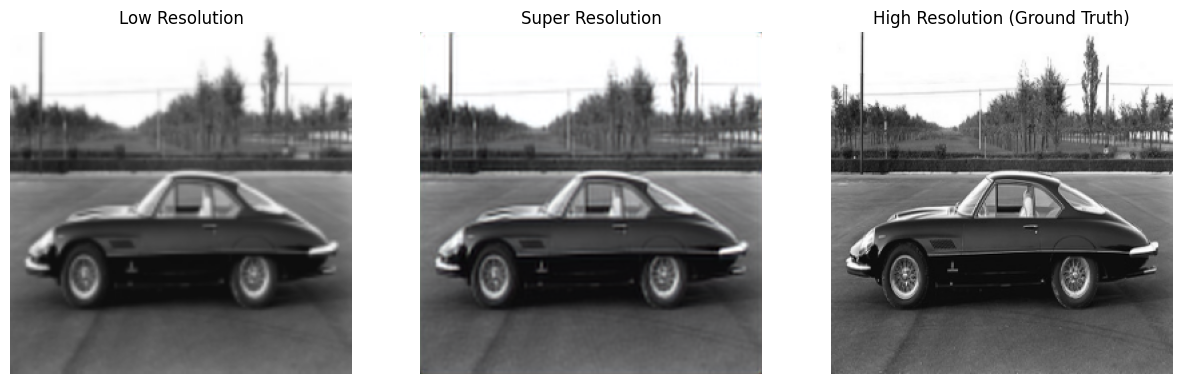

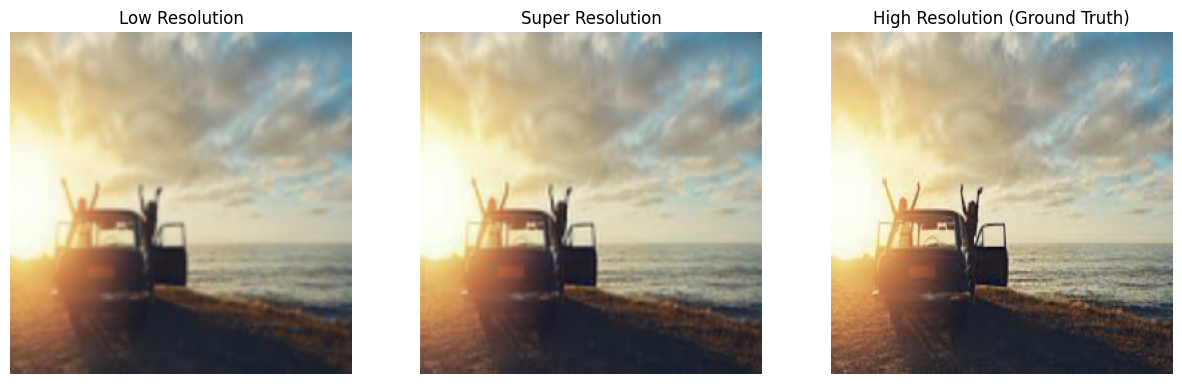

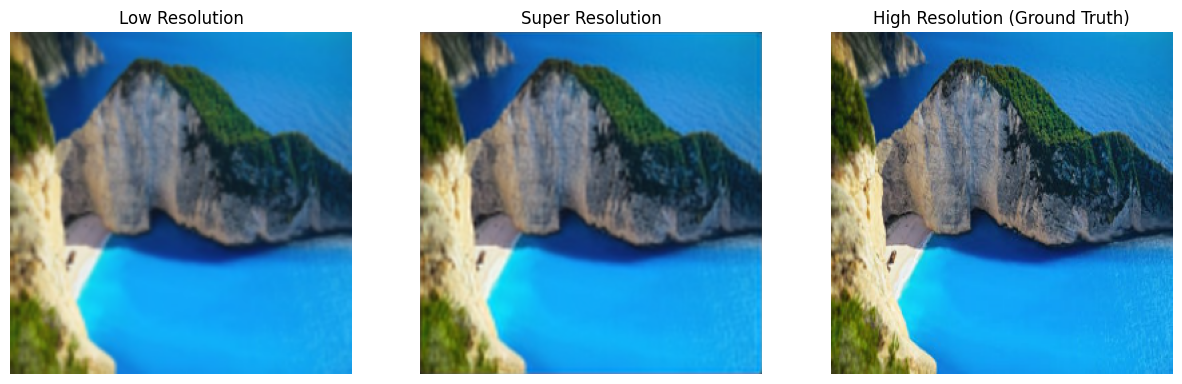

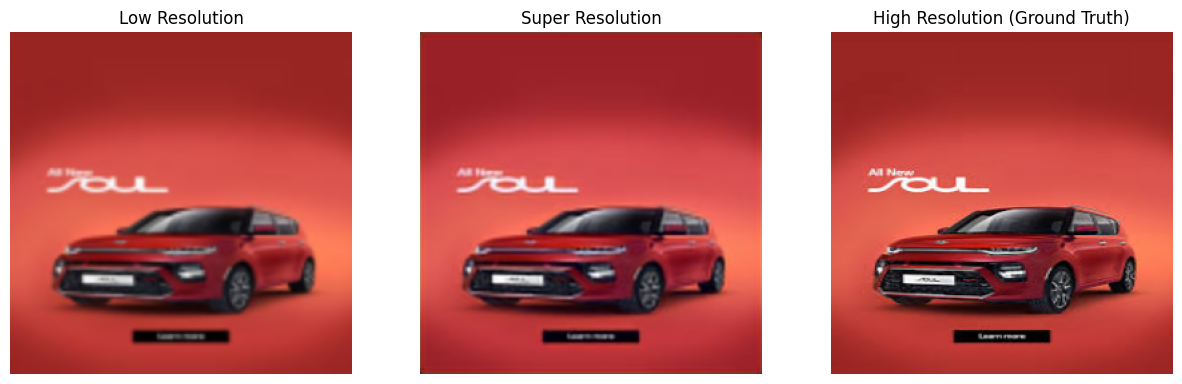

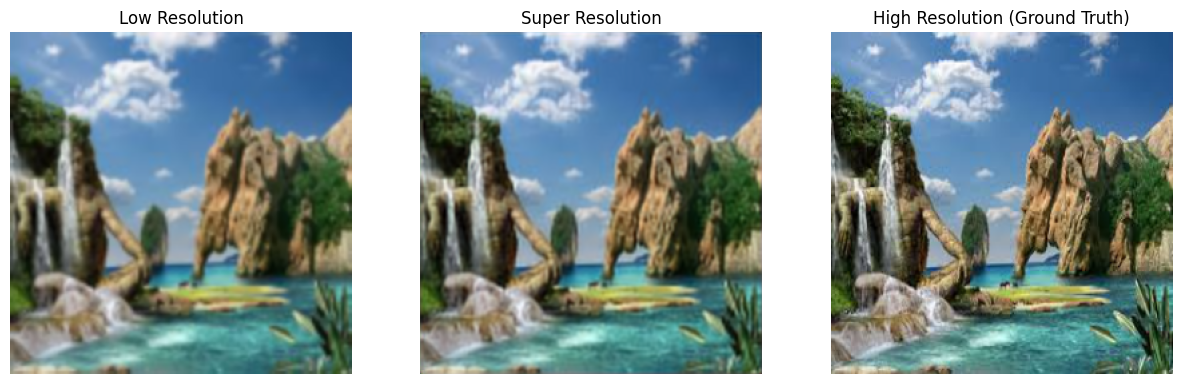

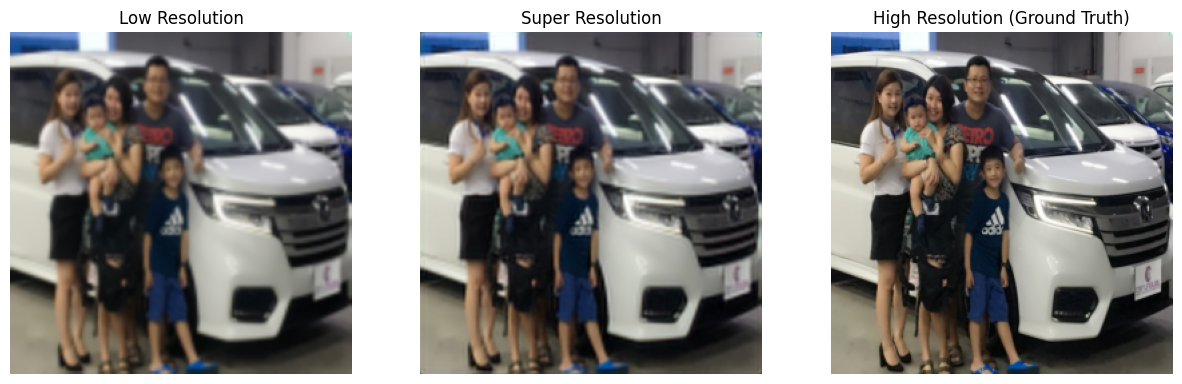

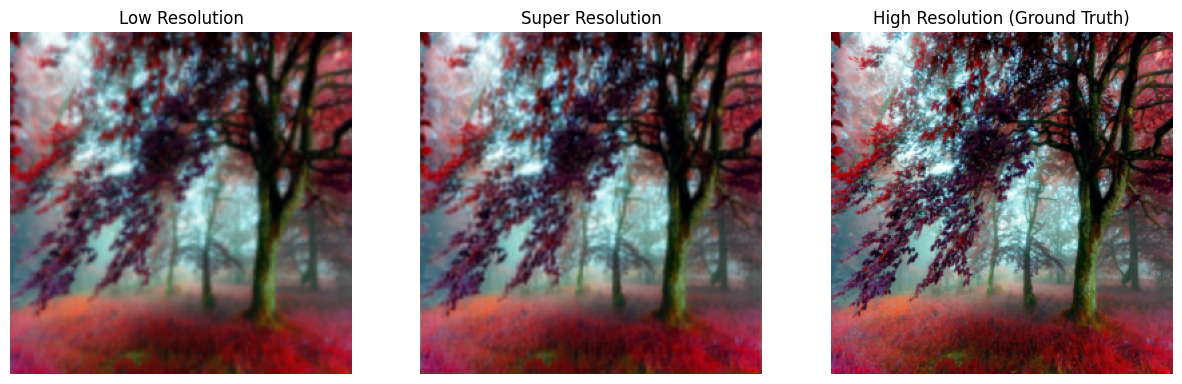

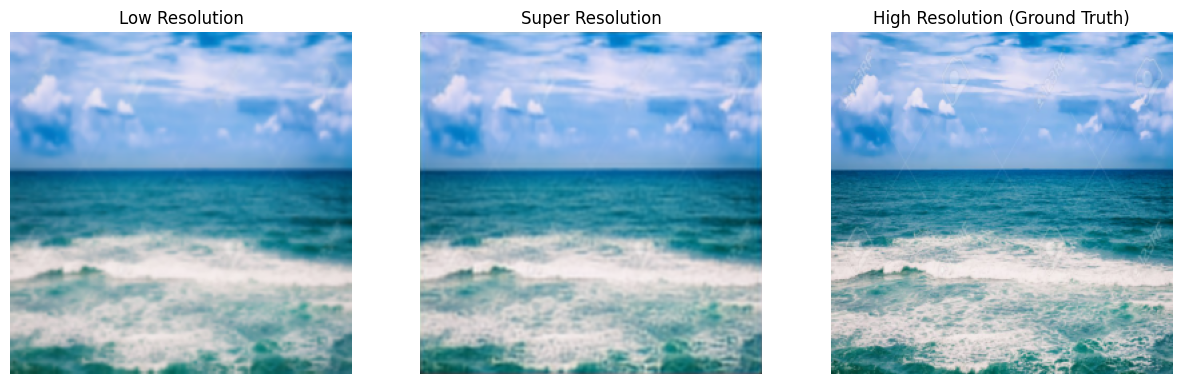

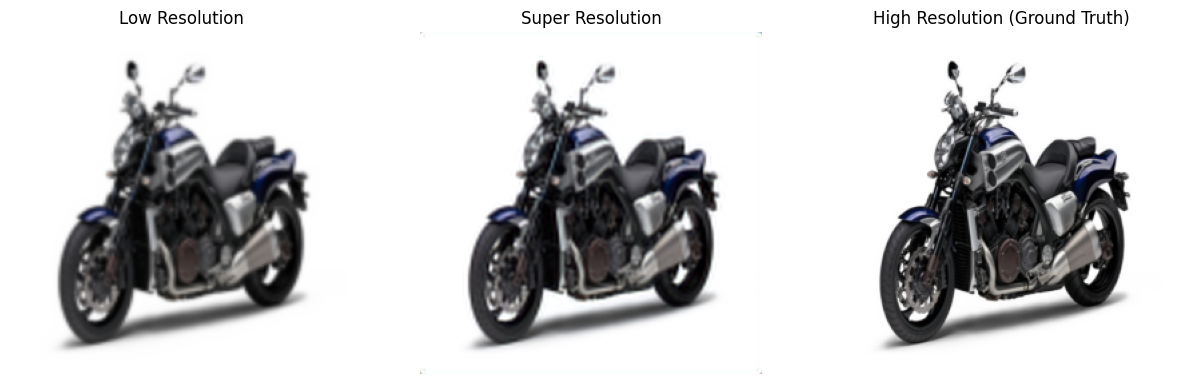

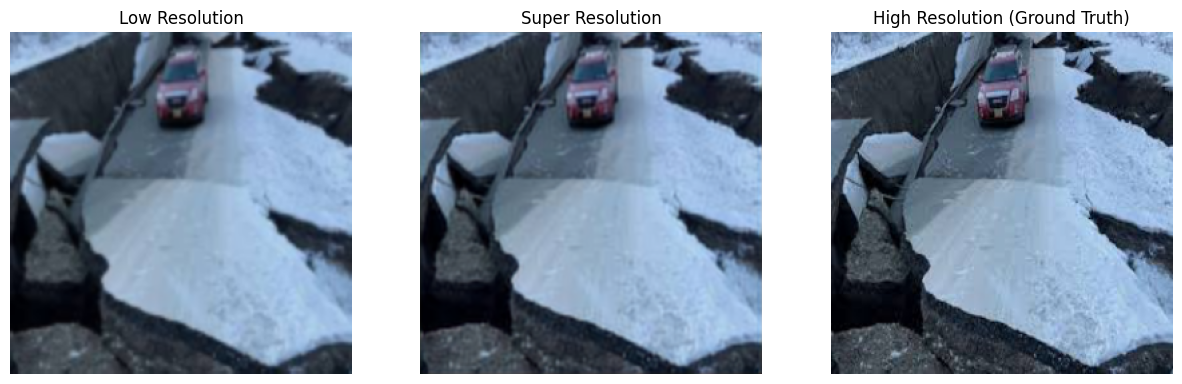

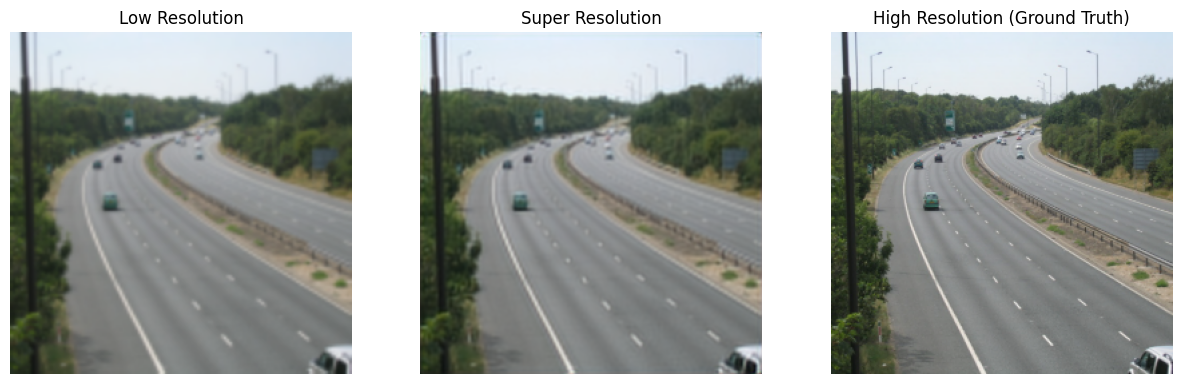

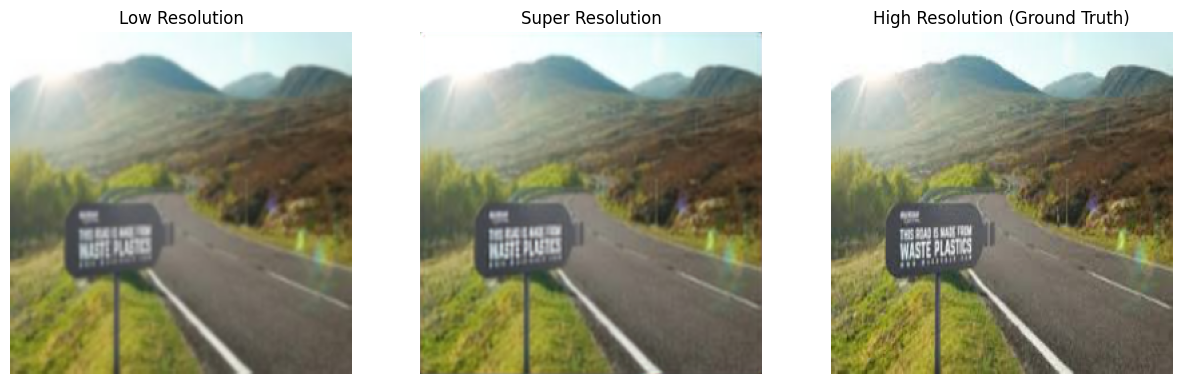

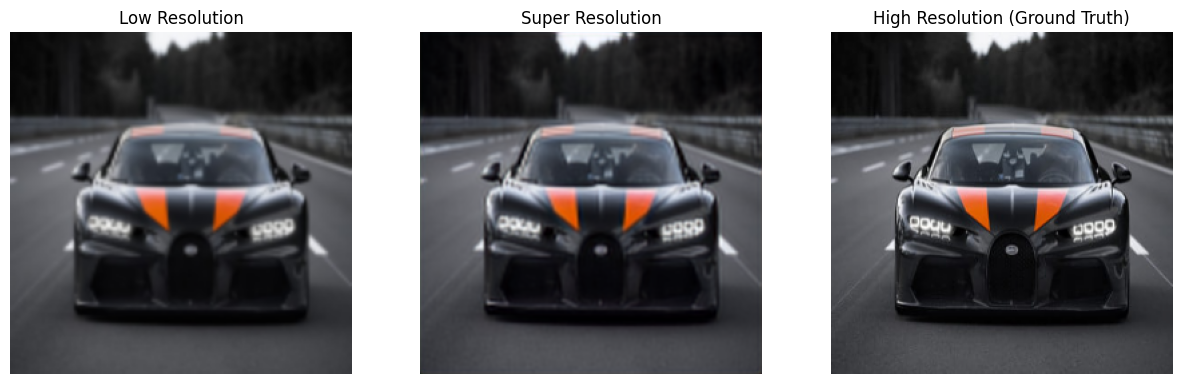

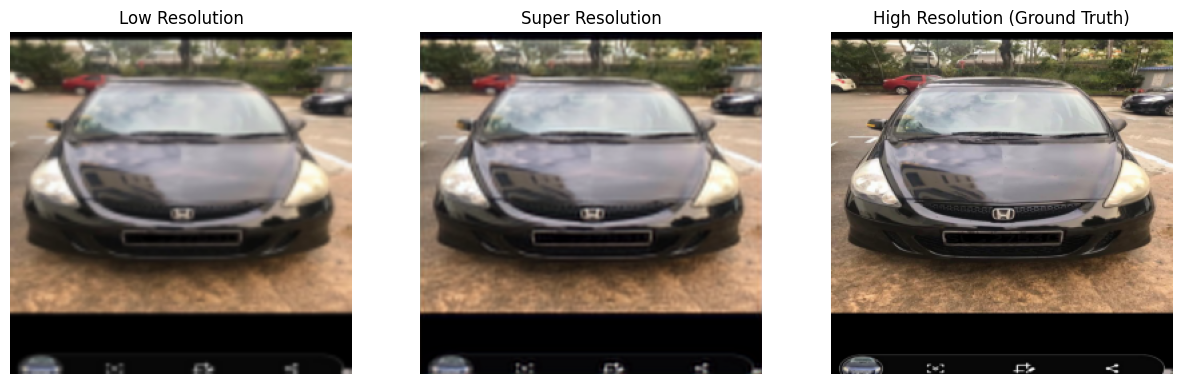

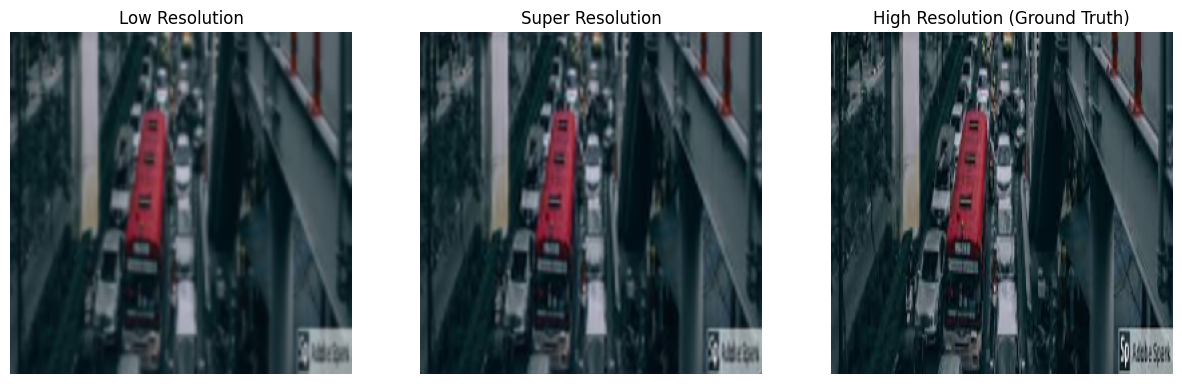

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate_images(model, './test_data/low_res_test', './test_data/high_res_test')

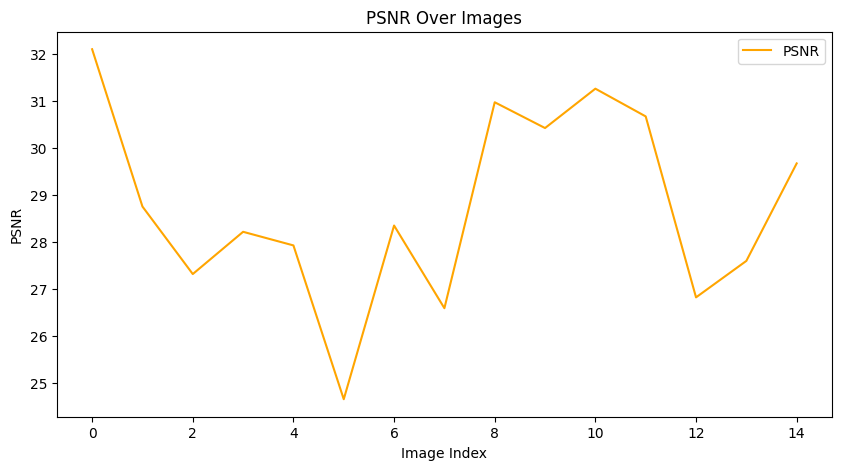

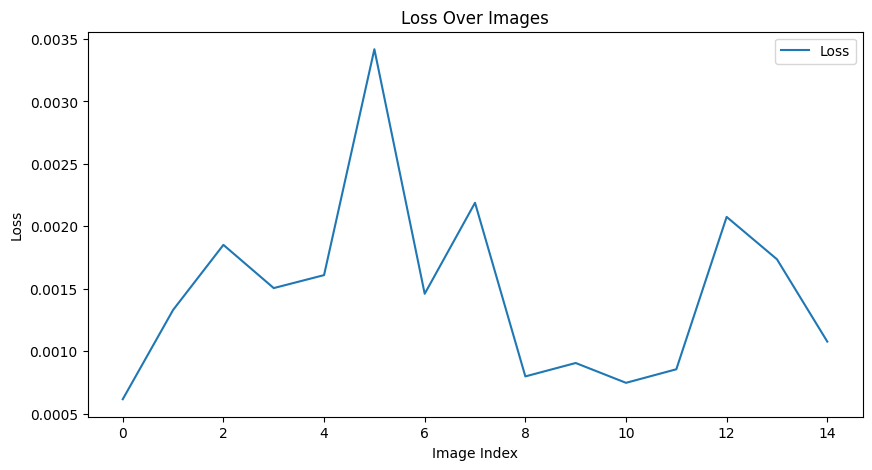

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(psnr_values, label='PSNR', color='orange')
plt.title('PSNR Over Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.title('Loss Over Images')
plt.xlabel('Image Index')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchvision import transforms

def super_resolve_image(model, lr_image_path, output_path):
    model.eval()
    lr_image = Image.open(lr_image_path).convert('RGB')
    to_tensor = ToTensor()
    lr_image_tensor = to_tensor(lr_image).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_image_tensor = model(lr_image_tensor)

    sr_image = sr_image_tensor.squeeze(0).cpu()
    sr_image = torch.clamp(sr_image, 0.0, 1.0)
    to_pil = transforms.ToPILImage()
    sr_image = to_pil(sr_image)
    sr_image.save(output_path)


In [ ]:
super_resolve_image(model, './test_data/test.jpg', './test_sr.jpg')
